In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e7/sample_submission.csv
/kaggle/input/playground-series-s4e7/train.csv
/kaggle/input/playground-series-s4e7/test.csv


# Setup 

In [2]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import f1_score as f1
from sklearn.metrics import confusion_matrix
from sklearn.metrics import *

#-- Pytorch specific libraries import -----#
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
df_train_raw = pd.read_csv('/kaggle/input/playground-series-s4e7/train.csv',index_col=0)
df_test_raw = pd.read_csv('/kaggle/input/playground-series-s4e7/test.csv',index_col=0)

In [4]:
data = df_train_raw.copy()
data.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


In [5]:
data['Gender'] = data['Gender'].map({'Male': 1, 'Female': 0})
data['Vehicle_Age'] = data['Vehicle_Age'].map({'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2})
data['Vehicle_Damage'] = data['Vehicle_Damage'].map({'Yes': 1, 'No': 0})

In [6]:
data.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
0,1,21,1,35.0,0,1,1,65101.0,124.0,187,0
1,1,43,1,28.0,0,2,1,58911.0,26.0,288,1
2,0,25,1,14.0,1,0,0,38043.0,152.0,254,0
3,0,35,1,1.0,0,1,1,2630.0,156.0,76,0
4,0,36,1,15.0,1,1,0,31951.0,152.0,294,0


# EDA

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11504798 entries, 0 to 11504797
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Gender                int64  
 1   Age                   int64  
 2   Driving_License       int64  
 3   Region_Code           float64
 4   Previously_Insured    int64  
 5   Vehicle_Age           int64  
 6   Vehicle_Damage        int64  
 7   Annual_Premium        float64
 8   Policy_Sales_Channel  float64
 9   Vintage               int64  
 10  Response              int64  
dtypes: float64(3), int64(8)
memory usage: 1.0 GB


In [8]:
data.isna().sum()

Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [9]:
data.describe()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07
mean,5.413510e-01,3.838356e+01,9.980220e-01,2.641869e+01,4.629966e-01,6.031073e-01,5.026798e-01,3.046137e+04,1.124254e+02,1.638977e+02,1.229973e-01
std,4.982872e-01,1.499346e+01,4.443120e-02,1.299159e+01,4.986289e-01,5.678559e-01,4.999928e-01,1.645475e+04,5.403571e+01,7.997953e+01,3.284341e-01
min,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.630000e+03,1.000000e+00,1.000000e+01,0.000000e+00
25%,0.000000e+00,2.400000e+01,1.000000e+00,1.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,2.527700e+04,2.900000e+01,9.900000e+01,0.000000e+00
50%,1.000000e+00,3.600000e+01,1.000000e+00,2.800000e+01,0.000000e+00,1.000000e+00,1.000000e+00,3.182400e+04,1.510000e+02,1.660000e+02,0.000000e+00
75%,1.000000e+00,4.900000e+01,1.000000e+00,3.500000e+01,1.000000e+00,1.000000e+00,1.000000e+00,3.945100e+04,1.520000e+02,2.320000e+02,0.000000e+00
max,1.000000e+00,8.500000e+01,1.000000e+00,5.200000e+01,1.000000e+00,2.000000e+00,1.000000e+00,5.401650e+05,1.630000e+02,2.990000e+02,1.000000e+00


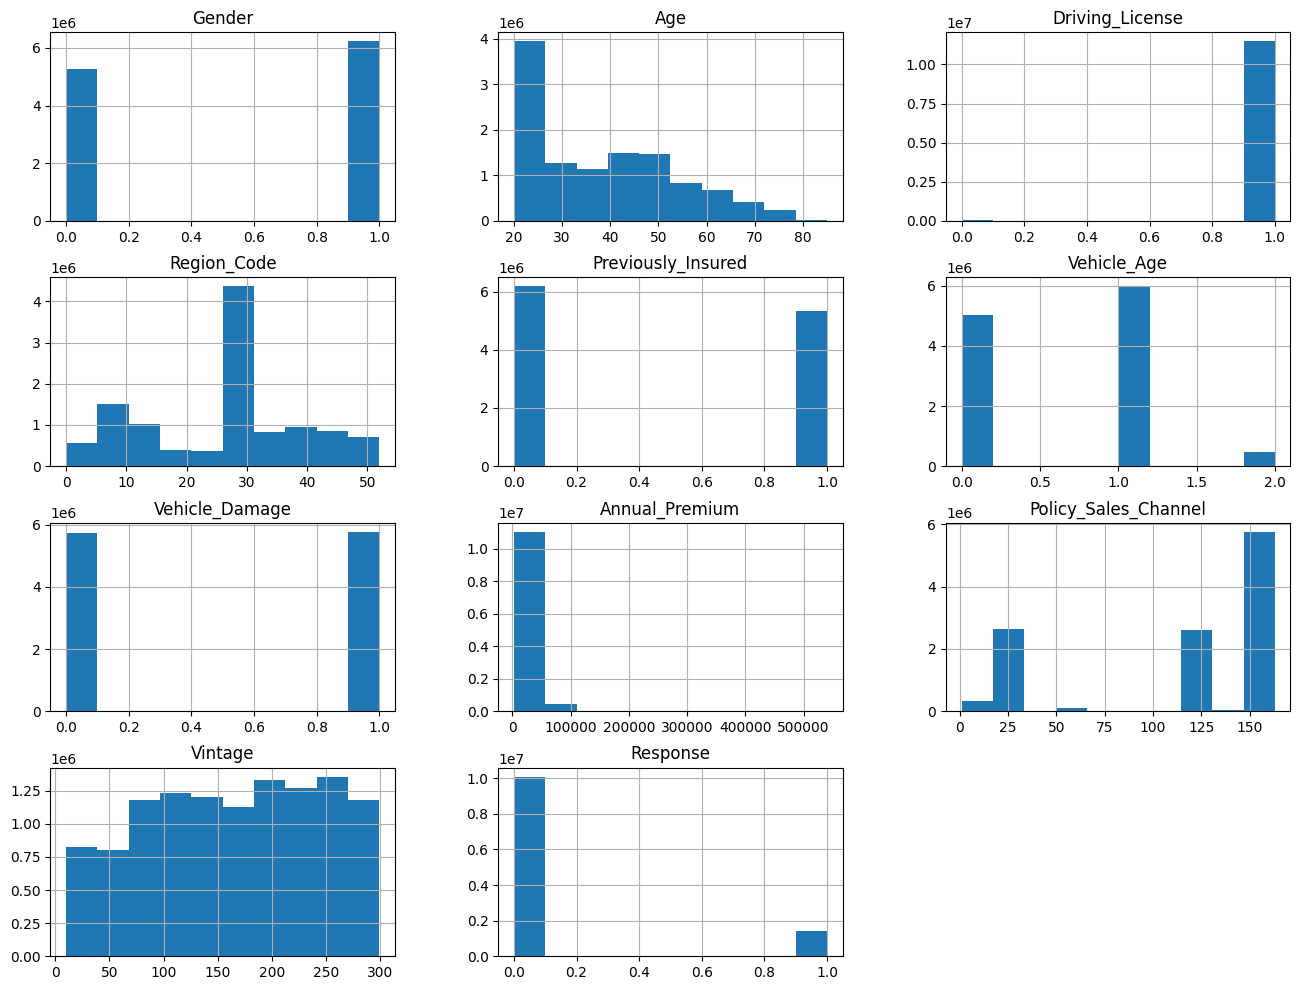

In [10]:
data.hist(figsize=(16, 12));

## data preparation

In [11]:
np.mean(data['Annual_Premium']), np.median(data['Annual_Premium'])

(30461.370410588694, 31824.0)

In [12]:
#data['Annual_Premium'] = np.where(data['Annual_Premium'] > 32000, 1, 0)

In [13]:
#data_sample= data.sample(frac=0.025, random_state=42)
#data_sample

## Prepare Datasets

In [14]:
X = data.drop(columns=['Response'], axis=1)
y = data['Response']
train_x,test_x,train_y,test_y = train_test_split(X,y,random_state=42)

In [15]:
y.value_counts()

Response
0    10089739
1     1415059
Name: count, dtype: int64

In [16]:
X.shape, y.shape

((11504798, 10), (11504798,))

In [17]:
scaler = preprocessing.MinMaxScaler()
x_train = scaler.fit_transform(train_x.values)
x_test =  scaler.fit_transform(test_x.values)

In [18]:
x_tensor =  torch.from_numpy(x_train).float()
y_tensor =  torch.from_numpy(train_y.values.ravel()).float()
xtest_tensor =  torch.from_numpy(x_test).float()
ytest_tensor =  torch.from_numpy(test_y.values.ravel()).float()

print("\nTrain set Tensors \n")
print(x_tensor)
print(y_tensor)
print("\nTest set Tensors \n")
print(xtest_tensor)
print(ytest_tensor)


Train set Tensors 

tensor([[0.0000, 0.1077, 1.0000,  ..., 0.0541, 0.9321, 0.3045],
        [1.0000, 0.0308, 1.0000,  ..., 0.0412, 0.9321, 0.8512],
        [0.0000, 0.0462, 1.0000,  ..., 0.0383, 0.9321, 0.7474],
        ...,
        [0.0000, 0.1385, 1.0000,  ..., 0.0000, 0.9321, 0.1730],
        [1.0000, 0.0462, 1.0000,  ..., 0.0000, 0.9815, 0.1903],
        [1.0000, 0.0462, 1.0000,  ..., 0.0000, 0.9321, 0.5779]])
tensor([0., 0., 0.,  ..., 0., 0., 0.])

Test set Tensors 

tensor([[0.0000, 0.3231, 1.0000,  ..., 0.0502, 0.9630, 0.1246],
        [0.0000, 0.3077, 1.0000,  ..., 0.0749, 0.0741, 0.8131],
        [1.0000, 0.1692, 1.0000,  ..., 0.0516, 0.9321, 0.0727],
        ...,
        [1.0000, 0.4308, 1.0000,  ..., 0.0621, 0.1790, 0.8858],
        [0.0000, 0.0769, 1.0000,  ..., 0.0543, 0.9321, 0.3218],
        [0.0000, 0.5231, 1.0000,  ..., 0.0828, 0.1543, 0.5571]])
tensor([0., 0., 0.,  ..., 0., 0., 0.])


In [19]:
#Define a batch size , 
bs = 64
#Both x_train and y_train can be combined in a single TensorDataset, which will be easier to iterate over and slice
y_tensor = y_tensor.unsqueeze(1)
train_ds = TensorDataset(x_tensor, y_tensor)
#Pytorch’s DataLoader is responsible for managing batches. 
#You can create a DataLoader from any Dataset. DataLoader makes it easier to iterate over batches
train_dl = DataLoader(train_ds, batch_size=bs)


#For the validation/test dataset
ytest_tensor = ytest_tensor.unsqueeze(1)
test_ds = TensorDataset(xtest_tensor, ytest_tensor)
test_loader = DataLoader(test_ds, batch_size=32)

In [20]:
n_input_dim = train_x.shape[1]

#Layer size
n_hidden1 = 300  # Number of hidden nodes
n_hidden2 = 100
n_output =  1   # Number of output nodes = for binary classifier


class ChurnModel(nn.Module):
    def __init__(self):
        super(ChurnModel, self).__init__()
        self.layer_1 = nn.Linear(n_input_dim, n_hidden1) 
        self.layer_2 = nn.Linear(n_hidden1, n_hidden2)
        self.layer_out = nn.Linear(n_hidden2, n_output) 
        
        
        self.relu = nn.ReLU()
        self.sigmoid =  nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(n_hidden1)
        self.batchnorm2 = nn.BatchNorm1d(n_hidden2)
        
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.sigmoid(self.layer_out(x))
        
        return x
    

model = ChurnModel()
print(model)

ChurnModel(
  (layer_1): Linear(in_features=10, out_features=300, bias=True)
  (layer_2): Linear(in_features=300, out_features=100, bias=True)
  (layer_out): Linear(in_features=100, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [21]:
#Loss Computation
loss_func = nn.BCELoss()
#Optimizer
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 50

In [22]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


2024-07-15 17:53:44.457380: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-15 17:53:44.457590: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-15 17:53:44.624509: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Num GPUs Available:  0


In [23]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [24]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        
        # Allow memory growth
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [25]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: nvidia-smi: command not found


In [ ]:
model.train()
train_loss = []
for epoch in range(epochs):
    #Within each epoch run the subsets of data = batch sizes.
    for xb, yb in train_dl:
        y_pred = model(xb)            # Forward Propagation
        loss = loss_func(y_pred, yb)  # Loss Computation
        optimizer.zero_grad()         # Clearing all previous gradients, setting to zero 
        loss.backward()               # Back Propagation
        optimizer.step()              # Updating the parameters 
    #print("Loss in iteration :"+str(epoch)+" is: "+str(loss.item()))
    train_loss.append(loss.item())
print('Last iteration loss value: '+str(loss.item()))

In [ ]:
plt.plot(train_loss)
plt.show()

In [ ]:
import itertools

y_pred_list = []
model.eval()
#Since we don't need model to back propagate the gradients in test set we use torch.no_grad()
# reduces memory usage and speeds up computation
with torch.no_grad():
    for xb_test,yb_test  in test_loader:
        y_test_pred = model(xb_test)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.detach().numpy())

#Takes arrays and makes them list of list for each batch        
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
#flattens the lists in sequence
ytest_pred = list(itertools.chain.from_iterable(y_pred_list))

In [ ]:
y_true_test = test_y.values.ravel()
conf_matrix = confusion_matrix(y_true_test ,ytest_pred)
print("Confusion Matrix of the Test Set")
print("-----------")
print(conf_matrix)
print("Precision of the MLP :\t"+str(precision_score(y_true_test,ytest_pred)))
print("Recall of the MLP    :\t"+str(recall_score(y_true_test,ytest_pred)))
print("F1 Score of the Model :\t"+str(f1_score(y_true_test,ytest_pred)))